In [1]:
from binance.client import Client
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from datetime import datetime
from libs import *
from utils import *

with open("C:\\Users\\thang\\OneDrive\\Documents\\binance_cres\\api_key.txt") as api_file:
    api_key = api_file.readline()
with open("C:\\Users\\thang\\OneDrive\\Documents\\binance_cres\\sec_key.txt") as api_file:
    api_secret = api_file.readline()
# make binance object
client = Client(api_key, api_secret)

# Parameters
target_coin = 'ETCUSDT'


In [2]:
## Raw data
# agg_trades = client.aggregate_trade_iter(symbol='ETCUSDT', start_str='60 minutes ago UTC')

# # iterate over the trade iterator
# df_dict = {'a':[], 'p':[], 'q':[], 'f':[], 'l':[],'T':[], 'm':[],'M':[]}
# for trade in agg_trades:
#     # prices.append(trade["p"])
#     df_dict['a'].append(trade["a"])
#     df_dict['p'].append(trade["p"])
#     df_dict['q'].append(trade["q"])
#     df_dict['f'].append(trade["f"])
#     df_dict['l'].append(trade["l"])
#     df_dict['T'].append(trade["T"])
#     df_dict['m'].append(trade["m"])
#     df_dict['M'].append(trade["M"])
#     print(trade)

# df = pd.DataFrame.from_dict(df_dict)
# interested_df = df[['p','q','T']]  # get price as p, quantity as q, Time as T

In [3]:
avg_data = client.get_klines(symbol=target_coin, interval=Client.KLINE_INTERVAL_30MINUTE)
cols = ['open_time',  # Open time
            'open',  # Open
            'high',  # High
            'low',  # Low
            'close',  # Close
            'vol',  # Volume
            'close_time',  # Close time
            'quote_ass_vol',  # Quote asset volume
            'no_trade',  # Number of trades
            'base_ass_vol',  # Taker buy base asset volume
            'qoute_ass_vol',  # Taker buy quote asset volume
            'ignore']   # Can be ignored
df = pd.DataFrame(avg_data, 
    columns = cols)

important_features_df = df[['close','close_time','vol']]  # get important features
important_features_df.close_time = important_features_df.close_time.apply(lambda x: x/1000)  # convert milisecond to second

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [4]:
important_features_df.describe()  # inspection

,close_time
count,5.000000e+02
mean,1.620298e+09
std,2.600673e+05
min,1.619849e+09
25%,1.620073e+09
50%,1.620298e+09
75%,1.620522e+09
max,1.620747e+09


In [5]:
important_features_df = data_converter(important_features_df)

c:\Users\thang\Documents\coin_pred\utils.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(date_time * (2 * np.pi / day))
c:\Users\thang\Documents\coin_pred\utils.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(date_time * (2 * np.pi / day))
c:\Users\thang\Documents\coin_pred\utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Text(0.5, 1.0, 'Time of day signal')

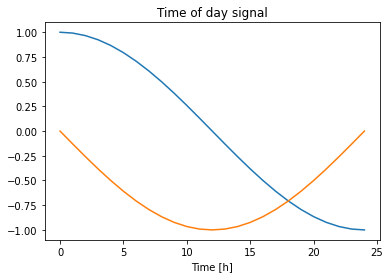

In [6]:
plt.plot(np.array(important_features_df['Day sin'])[:25])
plt.plot(np.array(important_features_df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [7]:
# data splitting
# column_indices = {name: i for i, name in enumerate(important_features_df.columns)}

n = len(important_features_df)
train_df = important_features_df[0:int(n*0.7)]  # 70% train data
val_df = important_features_df[int(n*0.7):int(n*0.9)]  # 20% val data
test_df = important_features_df[int(n*0.9):]  # 10% test data

num_features = important_features_df.shape[1]

In [8]:
# normalization
train_mean = train_df.mean()
train_std = train_df.std()

# make sure train data as main distribution
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


In [9]:
time_predictors = 24  # number of historical data as predictor
time_shift = 24  # number of timestamp to target
label_width = 1  # number of predicting timestamp

In [10]:
# prepare data
single_step_window = WindowGenerator(
    input_width=24, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['close'])
single_step_window

# model
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [13]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [14]:
# main model
linear = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    # tf.keras.layers.Reshape([1, -1]),
])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


# training setting

MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [15]:
history = compile_and_fit(lstm_model, single_step_window)
# linear.summary()
val_performance = {}
performance = {}
val_performance['Linear'] = lstm_model.evaluate(single_step_window.val)
performance['Linear'] = lstm_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 35ms/step - loss: 1.5444 - mean_absolute_error: 1.1029 - val_loss: 1.6371 - val_mean_absolute_error: 1.2706
Epoch 2/20
11/11 [==============================] - 0s 10ms/step - loss: 0.9633 - mean_absolute_error: 0.8686 - val_loss: 0.9247 - val_mean_absolute_error: 0.9499
Epoch 3/20
11/11 [==============================] - 0s 10ms/step - loss: 0.5800 - mean_absolute_error: 0.6674 - val_loss: 0.4570 - val_mean_absolute_error: 0.6474
Epoch 4/20
11/11 [==============================] - 0s 10ms/step - loss: 0.3223 - mean_absolute_error: 0.4753 - val_loss: 0.1801 - val_mean_absolute_error: 0.3334
Epoch 5/20
11/11 [==============================] - 0s 10ms/step - loss: 0.1759 - mean_absolute_error: 0.3041 - val_loss: 0.1162 - val_mean_absolute_error: 0.2441
Epoch 6/20
11/11 [==============================] - 0s 11ms/step - loss: 0.1367 - mean_absolute_error: 0.2606 - val_loss: 0.1338 - val_mean_absolute_error: 0.2963
Epoch 7/20
3/3 [======

len of input 32


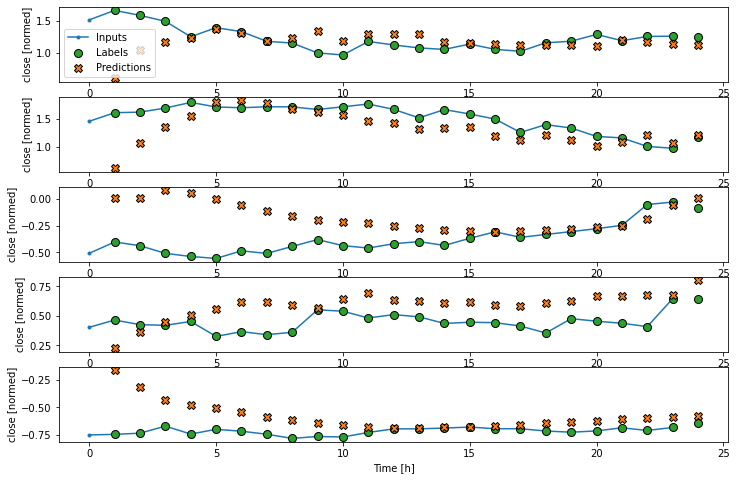

In [30]:
wide_window.plot(lstm_model, max_subplots=5)

In [16]:
lstm_model.layers[0].states

[None, None]

In [17]:
plt.bar(x = range(len(train_df.columns)),
        height=lstm_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

AttributeError: 'LSTM' object has no attribute 'kernel'

In [18]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)
